# Assignment 2 - Q01

1. Augmentation techniques (scaling, rotation, noise) applied effectively
2. VAE Implementation, VAE Training and good quality fake Signature Generation from latent space
3. GAN Implementation, Training with generator and discriminator functioning properly and generating signatures that closely resemble originals.
4. Clear evaluation using reconstruction loss and visual comparison to originals.



# <span style = "color : red" >Step 1</span>

# <span style = "color :green" >VAE</span>

In [1]:
# importing packages
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
epochs = 5

In [3]:
import torch
from torch.utils.data import DataLoader

In [14]:
input_path = ".\\Q1signatures"

## Loading Dataset

In [15]:
def load_images_from_folder(input_path):
    images = []
    labels = []
    for person_folder in os.listdir(input_path):
        person_folder_path = os.path.join(input_path, person_folder)
        for image_name in os.listdir(person_folder_path):
            img_path = os.path.join(person_folder_path, image_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
            if img is not None:
                img = cv2.resize(img, (128, 128))  # Resize to a fixed size
                images.append(img)
                labels.append(person_folder)  # Assign label as the person's folder
    images = np.array(images).astype('float32') / 255.0  # Normalize pixel values
    images = np.expand_dims(images, axis=-1)  # Add channel dimension for grayscale
    return np.array(images), np.array(labels)

input_path = ".\\Q1signatures"
images, labels = load_images_from_folder(input_path)

## <span style = 'color:cyan'>1. Augmentation techniques (scaling, rotation, noise) applied effectively</span>

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

# Augment the images
def augment_images(images, datagen):
    augmented_images = []
    for img in images:
        img = np.expand_dims(img, axis=0)
        for _ in range(5):  # Generate 5 augmented versions per image
            augmented_image = datagen.flow(img, batch_size=1).next()[0]
            augmented_images.append(augmented_image)
    return np.array(augmented_images)

augmented_images = augment_images(images, datagen)


## <span style = 'color:cyan'>2. VAE Implementation, VAE Training and good quality fake Signature Generation from latent space</span>

### Encoder

In [17]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

latent_dim = 16  # Size of the latent space

# Encoder
def build_encoder():
    inputs = Input(shape=(128, 128, 1))  # Input is a 128x128 grayscale image
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    mu = Dense(latent_dim)(x)  # Mean vector
    log_var = Dense(latent_dim)(x)  # Log variance vector

    # Sampling function for the reparameterization trick
    def sampling(args):
        mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
        return mu + K.exp(log_var / 2) * epsilon

    z = Lambda(sampling)([mu, log_var])

    encoder = Model(inputs, [mu, log_var, z], name='encoder')
    return encoder

encoder = build_encoder()
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 128, 128, 32  320         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 128, 128, 64  18496       ['conv2d_2[0][0]']               
                                )                                                           

### Decoder

In [4]:
# Decoder
def build_decoder():
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(128 * 128, activation='relu')(latent_inputs)
    x = Reshape((128, 128, 1))(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    outputs = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

    decoder = Model(latent_inputs, outputs, name='decoder')
    return decoder

decoder = build_decoder()
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_3 (Dense)             (None, 16384)             278528    
                                                                 
 reshape (Reshape)           (None, 128, 128, 1)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 128, 128, 64)     640       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 128, 32)     18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 128, 1)      289 

## Loss

In [7]:
from tensorflow.keras.losses import binary_crossentropy

# VAE Loss (reconstruction + KL divergence)
def vae_loss(inputs, outputs, mu, log_var):
    reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs)) * 128 * 128
    kl_loss = -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
    return K.mean(reconstruction_loss + kl_loss)


## Training

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Combine encoder and decoder into the full VAE model
inputs = Input(shape=(128, 128, 1))
mu, log_var, z = encoder(inputs)
outputs = decoder(z)

vae = Model(inputs, outputs, name='vae')
vae.add_loss(vae_loss(inputs, outputs, mu, log_var))
vae.compile(optimizer=Adam())

# Define the ModelCheckpoint callback to save the model every 10 epochs
checkpoint_callback = ModelCheckpoint(
    filepath='vae_model_epoch_{epoch:02d}.h5',  # Save model with epoch number
    save_weights_only=True,                     # Save only model weights
    period=10,                                  # Save every 10 epochs (deprecated in latest versions; use 'save_freq' instead)
    save_freq='epoch',                         # Save after each epoch
    verbose=1                                   # Verbosity mode, 1 = print messages when saving
)

# Train the VAE with the checkpoint callback
vae.fit(augmented_images, augmented_images, epochs=50, batch_size=32, validation_split=0.2, callbacks=[checkpoint_callback])


Epoch 1/50
110/110 [==============================] - 362s 3s/step - loss: 242218.0156 - val_loss: 10743.1045
Epoch 2/50
110/110 [==============================] - 343s 3s/step - loss: 10714.5156 - val_loss: 10733.5850
Epoch 3/50
110/110 [==============================] - 341s 3s/step - loss: 10701.2266 - val_loss: 10715.9316
Epoch 4/50
110/110 [==============================] - 339s 3s/step - loss: 10675.3740 - val_loss: 10692.5693
Epoch 5/50
110/110 [==============================] - 321s 3s/step - loss: 10655.1514 - val_loss: 10674.1504
Epoch 6/50
110/110 [==============================] - 321s 3s/step - loss: 10643.1045 - val_loss: 10666.0234
Epoch 7/50
110/110 [==============================] - 318s 3s/step - loss: 10635.0498 - val_loss: 10659.1143
Epoch 8/50
110/110 [==============================] - 331s 3s/step - loss: 10628.8750 - val_loss: 10654.0469
Epoch 9/50
110/110 [==============================] - 321s 3s/step - loss: 10625.6855 - val_loss: 10650.7061
Epoch 10/50
110/11

## Save Model

In [20]:
# Save the encoder model
encoder.save("vae_encoder.h5")

# Save the decoder model
decoder.save("vae_decoder.h5")

# Save the full VAE model
vae.save("vae_full.h5")


## Load Model

In [ ]:
from tensorflow.keras.models import load_model

# Load the generator and discriminator models
encoder = load_model('vae_encoder.h5')
decoder = load_model('decoder.h5')
vae = load_model('vae_full.h5')

1/1 [==============================] - 1s 882ms/step


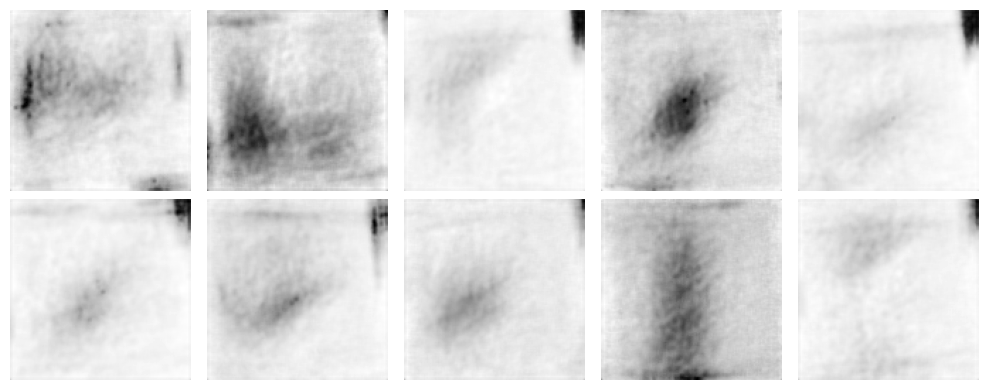

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate images from the trained decoder
def generate_images(decoder, num_images=10, latent_dim=latent_dim):
    # Generate random latent vectors from a standard normal distribution
    random_latent_vectors = np.random.normal(size=(num_images, latent_dim))

    # Use the decoder to generate images from the latent vectors
    generated_images = decoder.predict(random_latent_vectors)

    # Plot the generated images
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(generated_images[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Assuming latent_dim is the dimension of the latent space
latent_dim = z.shape[-1]  # Replace with the actual size of your latent space if different

# Generate and visualize 10 new images
generate_images(decoder, num_images=10, latent_dim=latent_dim)


1/1 [==============================] - 0s 485ms/step


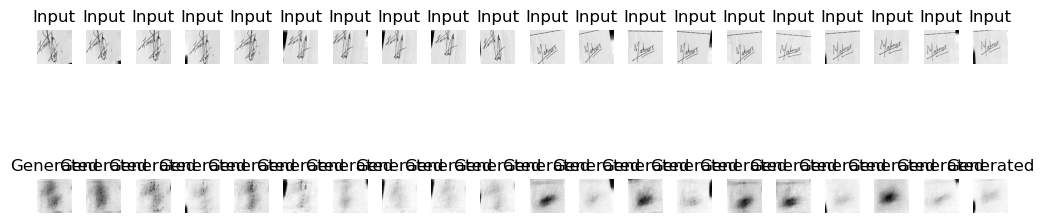

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Function to visualize input images and their corresponding generated images
def visualize_input_and_generated_images(encoder, decoder, input_images, num_images=10):
    # Select a subset of input images
    selected_images = input_images[:num_images]

    # Encode the input images to get the latent vectors (ensure to get the 'z' output only)
    _, _, latent_vectors = encoder.predict(selected_images)

    # Use the decoder to generate images from the latent vectors
    generated_images = decoder.predict(latent_vectors)

    # Plot the input images and their corresponding generated images side by side
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Display the original input image
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(selected_images[i].squeeze(), cmap='gray')
        plt.title("Input")
        plt.axis('off')

        # Display the generated image
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(generated_images[i].squeeze(), cmap='gray')
        plt.title("Generated")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize 10 input images and their generated counterparts
visualize_input_and_generated_images(encoder, decoder, augmented_images, num_images=20)


## <span style = 'color :cyan'>3. GAN Implementation, Training with generator and discriminator</span>

In [26]:
import tensorflow as tf


## Generator

In [27]:
def build_generator():
    model = tf.keras.Sequential([
        Dense(128 * 128, activation='relu', input_dim=latent_dim),
        Reshape((128, 128, 1)),
        Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
        Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
        Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')
    ])
    return model

generator = build_generator()
generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 16384)             278528    
                                                                 
 reshape_1 (Reshape)         (None, 128, 128, 1)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 128, 128, 64)     640       
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 128, 128, 32)     18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 128, 128, 1)      289       
 ranspose)                                                       
                                                        

## Discriminator

In [28]:
def build_discriminator():
    model = tf.keras.Sequential([
        Conv2D(64, (3, 3), padding='same', input_shape=(128, 128, 1)),
        Conv2D(128, (3, 3), padding='same'),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()
discriminator.compile(optimizer=Adam(), loss='binary_crossentropy')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      640       
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 flatten_2 (Flatten)         (None, 2097152)           0         
                                                                 
 dense_8 (Dense)             (None, 1)                 2097153   
                                                                 
Total params: 2,171,649
Trainable params: 2,171,649
Non-trainable params: 0
_________________________________________________________________


## Training 

In [29]:
import tensorflow as tf

def train_gan(generator, discriminator, images, epochs=50, batch_size=32):
    # Combined GAN model
    gan_input = Input(shape=(latent_dim,))
    generated_img = generator(gan_input)
    discriminator.trainable = False
    gan_output = discriminator(generated_img)
    gan = Model(gan_input, gan_output)
    gan.compile(optimizer=Adam(), loss='binary_crossentropy')

    for epoch in range(epochs):
        idx = np.random.randint(0, images.shape[0], batch_size)
        real_imgs = images[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_imgs = generator.predict(noise)

        # Train discriminator
        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        print(f"Epoch {epoch + 1}/{epochs}, D Loss: {d_loss}, G Loss: {g_loss}")

train_gan(generator, discriminator, augmented_images)


1/1 [==============================] - 1s 1s/step
Epoch 1/50, D Loss: 48.916189312934875, G Loss: 15.00823974609375
1/1 [==============================] - 1s 1s/step
Epoch 2/50, D Loss: 20.478079795837402, G Loss: 0.0035987754818052053
1/1 [==============================] - 1s 1s/step
Epoch 3/50, D Loss: 0.001222295715706423, G Loss: 14.282265663146973
1/1 [==============================] - 1s 1s/step
Epoch 4/50, D Loss: 14.086832046508789, G Loss: 1.7414931789971888e-05
1/1 [==============================] - 1s 1s/step
Epoch 5/50, D Loss: 5.4435130363100654, G Loss: 3.0996670722961426
1/1 [==============================] - 1s 1s/step
Epoch 6/50, D Loss: 1.8683202862739563, G Loss: 3.064866065979004
1/1 [==============================] - 1s 1s/step
Epoch 7/50, D Loss: 3.706315040588379, G Loss: 0.033725254237651825
1/1 [==============================] - 1s 1s/step
Epoch 8/50, D Loss: 1.1582533118780702, G Loss: 4.455163955688477
1/1 [==============================] - 1s 1s/step
Epoch 9

## Save Model

In [32]:
 # Save the models after the final epoch
generator.save('Q1_gan_generator_final.h5')
discriminator.save('Q1_gan_discriminator_final.h5')
print("Final models saved.")

Final models saved.


## Load Model 

conda install -c conda-forge h5py


In [14]:
from tensorflow.keras.models import load_model

# Load the generator and discriminator models
generator = load_model('Q1_gan_generator_final.h5')
discriminator = load_model('Q1_gan_discriminator_final.h5')


ImportError: Filepath looks like a hdf5 file but h5py is not available. filepath=Q1_gan_generator_final.h5

1/1 [==============================] - 0s 423ms/step


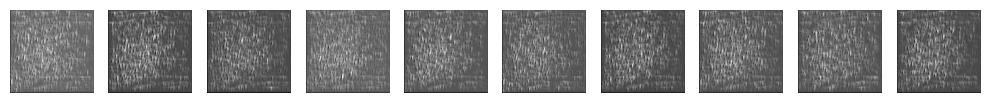

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def generate_and_display_images(generator, num_images=10, latent_dim=100):
    # Generate random noise as input for the generator
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    
    # Use the generator to create synthetic images
    generated_images = generator.predict(noise)

    # Rescale images to [0, 1] for display
    generated_images = 0.5 * generated_images + 0.5

    # Plot the generated images
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Assuming you have already trained and saved the generator
# Load the generator if not already loaded
# from tensorflow.keras.models import load_model
# generator = load_model('generator_final.h5')

# Generate and display images using the trained generator
generate_and_display_images(generator, num_images=10, latent_dim=generator.input_shape[1])


## <span style = 'color : cyan'>4. Clear evaluation using reconstruction loss and visual comparison to originals.</span>

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize original and reconstructed images (VAE)
def visualize_vae_reconstructions(vae, images, num_images=10):
    reconstructed_images = vae.predict(images[:num_images])
    
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Display original images
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Display reconstructed images
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed_images[i].reshape(128, 128), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.show()

# Function to visualize generated images (GAN)
def visualize_gan_generated_images(generator, latent_dim, num_images=10):
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    generated_images = generator.predict(noise)
    
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i].reshape(128, 128), cmap='gray')
        plt.title("Generated")
        plt.axis('off')

    plt.show()

# Assuming you have trained the VAE and GAN
visualize_vae_reconstructions(vae, test_images, num_images=10)
visualize_gan_generated_images(generator, latent_dim=100, num_images=10)
